In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-data-cleaned-hindi/test_data.csv
/kaggle/input/t5-fine-tuned/mt5_model.pt/config.json
/kaggle/input/t5-fine-tuned/mt5_model.pt/model.safetensors
/kaggle/input/t5-fine-tuned/mt5_model.pt/generation_config.json
/kaggle/input/t5-fine-tuned/mt5_tokenizer.json/spiece.model
/kaggle/input/t5-fine-tuned/mt5_tokenizer.json/tokenizer.json
/kaggle/input/t5-fine-tuned/mt5_tokenizer.json/tokenizer_config.json
/kaggle/input/t5-fine-tuned/mt5_tokenizer.json/special_tokens_map.json
/kaggle/input/t5-new-summary/newSummary.csv
/kaggle/input/result-summaries/res.csv


In [2]:
data = pd.read_csv("/kaggle/input/test-data-cleaned-hindi/test_data.csv")

In [ ]:
import torch
from transformers import MBartForConditionalGeneration,MBartTokenizer, AutoTokenizer ,DataCollatorForSeq2Seq, Trainer, TrainingArguments, AutoModelForSeq2SeqLM
from torch.utils.data import Dataset, DataLoader

In [ ]:
class Seq2SeqDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.input_text = data['Text_Cleaned'].tolist()
        self.labels = data['Summary_Cleaned'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.input_text)

    def __getitem__(self, idx):
        input_text = self.input_text[idx]
        label_text = self.labels[idx]

        # Tokenize the input text
        input_encodings = self.tokenizer(
            input_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        # Tokenize the label text to get its 'input_ids' and 'attention_mask'
        label_encodings = self.tokenizer(
            label_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': input_encodings['input_ids'].squeeze(),
            'attention_mask': input_encodings['attention_mask'].squeeze(),
            'labels': label_encodings['input_ids'].squeeze(),
        }


In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [ ]:
# Load the saved model
model = AutoModelForSeq2SeqLM.from_pretrained("/kaggle/input/t5-fine-tuned/mt5_model.pt")
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/t5-fine-tuned/mt5_tokenizer.json")

In [ ]:
text = "नमस्ते, आप कैसे हैं"
encoded_input = tokenizer(text, padding=True, truncation=True, max_length=20, return_tensors="pt")
print(encoded_input)


In [ ]:
test_dataset = Seq2SeqDataset(data, tokenizer)

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=4)

In [ ]:
# Move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
!pip install datasets

In [ ]:
# Move the model to the device (CPU or GPU)
model.to(device)

In [ ]:
import torch

In [ ]:
# Define the move_to_device function
def move_to_device(batch, device):
    if isinstance(batch, torch.Tensor):
        return batch.to(device)
    elif isinstance(batch, list):
        return [move_to_device(item, device) for item in batch]
    elif isinstance(batch, dict):
        return {key: move_to_device(value, device) for key, value in batch.items()}
    else:
        return batch  # If it's not a tensor, list, or dict, leave it as is

In [ ]:
# Initialize lists to store generated summarisaions and references
generated_summarisaions = []
references = []

# Generate summarisaions for the test dataset
for batch in test_dataloader:
    # Move the batch to CUDA
    batch = move_to_device(batch, 'cuda')

    input_text = batch['input_ids']  # Access the input_text using the correct key
    labels = batch['labels']  # Access the labels using the correct key

    # Generate summarisaions
    summarisaion_ids = model.generate(input_text, max_length=512, num_beams=4, length_penalty=2.0, early_stopping=True)

    # Move the summarisaion_ids to CPU to decode
    summarisaion_ids = summarisaion_ids.to('cpu')

    generated_summarisaion = tokenizer.batch_decode(summarisaion_ids, skip_special_tokens=True)

    generated_summarisaions.extend(generated_summarisaion)
    references.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))  # Decoding the label IDs

# Make sure to move generated_summarisaions back to CPU for evaluation if necessary
generated_summarisaions = [summarisaion if not isinstance(summarisaion, str) else summarisaion for summarisaion in generated_summarisaions]



In [ ]:
Summaries = pd.DataFrame(list(zip(references, generated_summarisaions)), columns =['Summary', 'T5Summary'])


In [ ]:
Summaries.iloc[0:20]

In [3]:
Summaries = pd.read_csv("/kaggle/input/t5-new-summary/newSummary.csv")
Summaries.drop(Summaries.columns[0], axis=1, inplace=True)
Summaries.head(10)

,Summary,T5Summary
0,मिशेल के जन्मदिन पर ओबामा ने दी शानदार दावत,अमेरिका की प्रथम महिला मिशेल ओबामा ने किया शान...
1,पतंजलि नमक का उड़ाया मजाक तो ट्रोल हो गए जावेद...,नमक के दाने समय के साथ जावेद जाफरी ने किया ट्रोल
2,शिवराज के साले को चुनाव लड़ना पड़ा भारी मिले स...,वारासिवनी विधानसभा सीट पर शिवराज सिंह के साले ...
3,रानी मुखर्जी को बेटी कहना काफी मुश्किल था शाहर...,ऋषि कपूर की फिल्म फैन रिलीज जानें क्या है वजह
4,उत्तराखंड में जारी रहेगा राष्ट्रपति शासन केंद्...,नैनीताल हाईकोर्ट के फैसले पर बोले अटॉर्नी जनरल...
5,कैसे पूरा होगा मोदी का भारत जोड़ो सपना कर्नाटक...,कर्नाटक में कन्नड़ फॉन्ट के इस्तेमाल करने की त...
6,मन्नत में चुपके से पहुंचीं अनुष्का क्या डर गए ...,अनुष्का शर्मा की फिल्म में शाहरुख खान के साथ क...
7,शौहर के जुल्म से परेशान थी बीवी मीडिया के सामन...,पति से ख़ुला लेने के लिए महिला ने दिया ख़ुला न...
8,गडकरी पर संघ का वरदहस्त,गडकरी पर लगे आरोपों के बारे में गुरुमूर्ति ने ...
9,नाहरगढ़ किले में फिर लिखे मिले चेतन सैनी के ना...,जयपुर नाहरगढ़ किले पर नारे लिखे गए थे 35 नारों...


In [5]:
#Summaries.to_csv("newSummary.csv")

In [6]:
data['Text_Cleaned'][0]

'अमेरिका की प्रथम महिला मिशेल ओबामा के जन्मदिन पर उनके पति राष्ट्रपति बराक ओबामा ने व्हाइट हाउस के करीब ही एक भोजनालय में शानदार दावत का आयोजन किया मिशेल ओबामा 48 वर्ष की हो गयी हैं अमेरिका के प्रथम दंपति अपने करीबी दोस्तों के साथ कड़ी सुरक्षा के बीच राष्ट्रपति भवन के करीब स्थित भोजनालय बीएलटी स्टीक में जमा हुए पहले भी विभिन्न भोजनालयों में यह जोड़ा जन्मदिन का जश्न मना चुका है बर्थडे गर्ल मिशेल के साथ ओबामा उनकी उम्र को लेकर लगातार हंसी-मजाक करते रहे हैं राष्ट्रपति ने चुटकी ली जब हमारी शादी हुयी तभी इस पर थोड़ा विवाद सा था क्योंकि वह मुझसे 20 वर्ष छोटी थीं लेकिन अब लगता है ठीक-ठाक है फ्रांसीसी शेफ और उद्यमी लौरेंट टूरोंडल द्वारा स्थापित यह रेस्टोरेंट बीएलटी प्रथम महिला को काफी भाता है क्योंकि वह पहले भी यहां आ चुकी हैं यह नहीं बताया गया कि इस युगल ने क्या-क्या आर्डर दिया पिछले सप्ताह उन्होंने अपना ट्विटर अकाउंट खोला था और सोमवार की शाम को नृत्य कौशल का भी प्रदर्शन किया था '

In [7]:
Summaries['Summary'][0]

'मिशेल के जन्मदिन पर ओबामा ने दी शानदार दावत'

In [8]:
Summaries['T5Summary'][0]

'अमेरिका की प्रथम महिला मिशेल ओबामा ने किया शानदार दावत'

### **Plotting Rouge Score**

In [9]:
!pip3 install rouge

In [10]:
from rouge import Rouge

In [11]:
rouge = Rouge()
score = rouge.get_scores(str(Summaries['T5Summary']), str(Summaries['Summary']), avg=True)
T5Rouge = pd.DataFrame(score).set_index([['recall','precision','f-measure']])
T5Rouge

,rouge-1,rouge-2,rouge-l
recall,0.378947,0.095238,0.357895
precision,0.404494,0.097087,0.382022
f-measure,0.391304,0.096154,0.369565


In [12]:
import plotly.express as px
import matplotlib.pyplot as plt

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



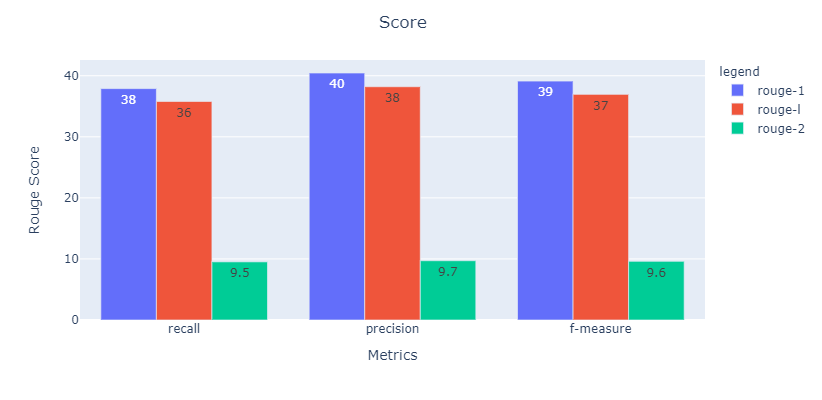

In [13]:
T5Rouge = T5Rouge[['rouge-1','rouge-l', 'rouge-2']]

fig = px.bar(T5Rouge*100, x=T5Rouge.index, y=T5Rouge.columns,
             barmode='group',
             text_auto='.2s',
             labels={
                     "Algo": "Algorithms",
                     "value": "Rouge Score",
                     "variable": "legend",
                     'index': "Metrics"
                 })
fig.update_layout( width=650,
                  height=400,
                title={
                  'text': "Score",
                  'y':.96,
                  'x':0.49,
                  'xanchor': 'center',
                  'yanchor': 'top'})

fig.show()


In [14]:
[i for i in Summaries['Summary'][:10]]

['मिशेल के जन्मदिन पर ओबामा ने दी शानदार दावत',
 'पतंजलि नमक का उड़ाया मजाक तो ट्रोल हो गए जावेद जाफरी',
 'शिवराज के साले को चुनाव लड़ना पड़ा भारी मिले सिर्फ 700 वोट',
 'रानी मुखर्जी को बेटी कहना काफी मुश्किल था शाहरुख खान',
 'उत्तराखंड में जारी रहेगा राष्ट्रपति शासन केंद्र की याचिका पर ने हाई कोर्ट के फैसले पर लगाई रोक',
 'कैसे पूरा होगा मोदी का भारत जोड़ो सपना कर्नाटक ने ऊंची की अपनी आवाज',
 'मन्नत में चुपके से पहुंचीं अनुष्का क्या डर गए शाहरुख',
 'शौहर के जुल्म से परेशान थी बीवी मीडिया के सामने ले लिया खुला',
 'गडकरी पर संघ का वरदहस्त',
 'नाहरगढ़ किले में फिर लिखे मिले चेतन सैनी के नारों से हड़कंप पुलिस ने दी सफाई']

In [15]:
[i for i in Summaries['T5Summary'][:10]]

['अमेरिका की प्रथम महिला मिशेल ओबामा ने किया शानदार दावत',
 'नमक के दाने समय के साथ जावेद जाफरी ने किया ट्रोल',
 'वारासिवनी विधानसभा सीट पर शिवराज सिंह के साले संजय मसानी को मिली 817 वोट',
 'ऋषि कपूर की फिल्म फैन रिलीज जानें क्या है वजह',
 'नैनीताल हाईकोर्ट के फैसले पर बोले अटॉर्नी जनरल- हमारे खेमे में कोई मायूसी नहीं',
 'कर्नाटक में कन्नड़ फॉन्ट के इस्तेमाल करने की तैयारी',
 'अनुष्का शर्मा की फिल्म में शाहरुख खान के साथ क्या हुआ रिलीज',
 'पति से ख़ुला लेने के लिए महिला ने दिया ख़ुला नोटिस',
 'गडकरी पर लगे आरोपों के बारे में गुरुमूर्ति ने दिया ये जवाब',
 'जयपुर नाहरगढ़ किले पर नारे लिखे गए थे 35 नारों की मौत']

In [4]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00


In [7]:
from evaluate import load
# Load BLEU
bleu_metric = load("bleu")

In [9]:
#Bilingual Evaluation Understudy (BLEU)
results_bleu = bleu_metric.compute(predictions=Summaries['T5Summary'], references=Summaries['Summary'])

In [10]:
# Create a DataFrame from the results_bleu dictionary
df = pd.DataFrame({
    'Metric': ['BLEU Score', '1-gram Precision', '2-gram Precision', '3-gram Precision', '4-gram Precision',
               'Brevity Penalty', 'Length Ratio', 'Translation Length', 'Reference Length'],
    'Value': [results_bleu['bleu']] + results_bleu['precisions'] +
             [results_bleu['brevity_penalty'], results_bleu['length_ratio'],
              results_bleu['translation_length'], results_bleu['reference_length']]
})

# Display the DataFrame
df.set_index('Metric', inplace=True)
df

,Value
Metric,
BLEU Score,0.089154
1-gram Precision,0.313743
2-gram Precision,0.131226
3-gram Precision,0.061919
4-gram Precision,0.032408
Brevity Penalty,0.935139
Length Ratio,0.937155
Translation Length,104608.000000
Reference Length,111623.000000
